# SPIDER CALIBRATION

## Imports

In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from dataclasses import dataclass
from matplotlib import gridspec

import scipy.signal
import scipy.optimize

import os

from DataFormat import DataFormat
from read_data import read_data

## Constants

In [3]:
# path to data files
DATA_PATH = "./data/"

# create the plot directory if it does not exist
if not os.path.exists("./plots"):
    os.makedirs("./plots")

# path to energy plots
E_PLOT_PATH = "./plots/energy-plots/"
if not os.path.exists(E_PLOT_PATH):
    os.makedirs(E_PLOT_PATH)

# path to calibration plots
CALIB_PLOT_PATH = "./plots/calib-plots/"
if not os.path.exists(CALIB_PLOT_PATH):
    os.makedirs(CALIB_PLOT_PATH)

# path to comparison plots 
COMP_PLOT_PATH = "./plots/comp-plots/"
if not os.path.exists(COMP_PLOT_PATH):
    os.makedirs(COMP_PLOT_PATH)

# reference energies
E_CM = 5805
E_AM = 5486
E_PU = 5155

# digitizers
BOARD_1_ID = 2
BOARD_2_ID = 3
BOARD_3_ID = 4
BOARD_4_ID = 5

# strips
STRIP_1_ID = 0
STRIP_2_ID = 1
STRIP_3_ID = 2
STRIP_4_ID = 3
STRIP_5_ID = 4
STRIP_6_ID = 5
STRIP_7_ID = 6

# channels
STARTING_CHANNEL = 0
N_CHANNELS_BOARD = 16
N_CHANNELS_STRIP = 8

# energy filters
E_MIN = 3000
E_MAX = 4000

# plot stuff
FONTSIZE = 22

# save figure flag
SAVE_FIG = False

## Functions

In [16]:
def plot_strip_channels(
    df,
    channel,
    fig, 
    idx    = 1, 
    nrows  = 2, 
    ncols  = 4,
    bins   = 200,
    label  = "",
    ecolor = "#06416D", 
    fcolor = "#7eb0d5",
):
    ax = fig.add_subplot(nrows, ncols, idx)
    
    ax.hist(
        df.loc[(df["strip_ch"]==channel), "energy"], 
        bins      = bins, 
        histtype  = "stepfilled", 
        edgecolor = ecolor, 
        facecolor = fcolor,
        label     = label
    )
    
    return ax

def customize_plot(
    ax, 
    fontsize = 16, 
    xleft    = None, 
    xright   = None, 
    ydown    = None, 
    yup      = None,
    title    = "Energy spectrum",
    ylabel   = "Counts",
    xlabel   = "Energy"
):
    
    ax.set_title(title,   fontsize = fontsize+4)
    ax.set_ylabel(ylabel, fontsize = fontsize+2)
    ax.set_xlabel(xlabel, fontsize = fontsize+2)
    
    ax.set_ylim(bottom = ydown, top   = yup)
    ax.set_xlim(left   = xleft, right = xright)
    
    ax.tick_params(axis="both", which="major", labelsize=fontsize, length=5)
    
    return ax


def filter_energy(df, emin = 3000, emax = 4000):
    return df.loc[((df["energy"] > 3000) & (df["energy"] < 4000)), ]

def make_binning(df, bins):
    hist, edges = np.histogram(df.loc[:, "energy"], bins=bins)
    centers = (edges[1:] + edges[:-1]) / 2
    return centers, hist, edges

def plot_binned_hist(
    x,
    h,
    fig, 
    idx    = 1, 
    nrows  = 1, 
    ncols  = 1,
    bins   = 200,
    lw     = 2,
    label  = None,
    ecolor = "#06416D", 
    fcolor = "#7eb0d5",
):
    ax = fig.add_subplot(nrows, ncols, idx)
    
    ax.hist(
        x, 
        weights   = h,
        bins      = bins, 
        histtype  = "stepfilled", 
        edgecolor = ecolor, 
        facecolor = fcolor,
        linewidth = lw,
        label     = label
    )
    
    return ax

def gaussian(x, n, u, s):
    return n*np.exp(- 0.5 * ( (x-u)/s )**2)

def linear(x, a, b):
    return a + b*x

def std_to_fwhm(std):
    return 2.35482 * std

def compute_resolution(mean, std):
    return std_to_fwhm(std) / mean

def compute_res_error(mean, std, mean_err, std_err):
    return np.sqrt( (std_to_fwhm(std_err) / mean)**2 + (std_to_fwhm(std) * mean_err / mean**2)**2 )

def compute_weighted_average(values, errors):
    """
    Compute the weighted average of a set of values with their errors.
    """
    return np.sum(values / errors**2) / np.sum(1 / errors**2)

def compute_weighted_average_error(values, errors):
    """
    Compute the error on the weighted average of a set of values with their errors.
    """
    return np.sqrt(1 / np.sum(1 / errors**2))

## Data

In [4]:
data_fname  = "DataR_run_1.root"
data_format = DataFormat()

df = read_data(DATA_PATH, data_fname, data_format)

# create a strip tag
df.loc[((df["board"] == BOARD_1_ID) & (df["channel"] >= STARTING_CHANNEL) & (df["channel"] < N_CHANNELS_STRIP)),   "strip"] = STRIP_1_ID
df.loc[((df["board"] == BOARD_1_ID) & (df["channel"] >= N_CHANNELS_STRIP) & (df["channel"] < 2*N_CHANNELS_STRIP)), "strip"] = STRIP_2_ID
df.loc[((df["board"] == BOARD_2_ID) & (df["channel"] >= STARTING_CHANNEL) & (df["channel"] < N_CHANNELS_STRIP)),   "strip"] = STRIP_3_ID
df.loc[((df["board"] == BOARD_2_ID) & (df["channel"] >= N_CHANNELS_STRIP) & (df["channel"] < 2*N_CHANNELS_STRIP)), "strip"] = STRIP_4_ID
df.loc[((df["board"] == BOARD_3_ID) & (df["channel"] >= STARTING_CHANNEL) & (df["channel"] < N_CHANNELS_STRIP)),   "strip"] = STRIP_5_ID
df.loc[((df["board"] == BOARD_3_ID) & (df["channel"] >= N_CHANNELS_STRIP) & (df["channel"] < 2*N_CHANNELS_STRIP)), "strip"] = STRIP_6_ID
df.loc[((df["board"] == BOARD_4_ID) & (df["channel"] >= STARTING_CHANNEL) & (df["channel"] < N_CHANNELS_STRIP)),   "strip"] = STRIP_7_ID

# create a strip channel tag ranging from 0 to 7
for strip_id in range(7):
    df.loc[(df["strip"] == strip_id), "strip_ch"] = df.loc[(df["strip"] == strip_id), "channel"] - df.loc[(df["strip"] == strip_id), "channel"].unique().max() + N_CHANNELS_STRIP - 1

# convert tags to small integers
df = df.astype({"strip": "int8", "strip_ch": "int8"})

## Strip 1

In [6]:
df_1 = df.loc[(df["strip"] == STRIP_1_ID), ]

# filter
df_1_filtered = filter_energy(df_1, E_MIN, E_MAX)

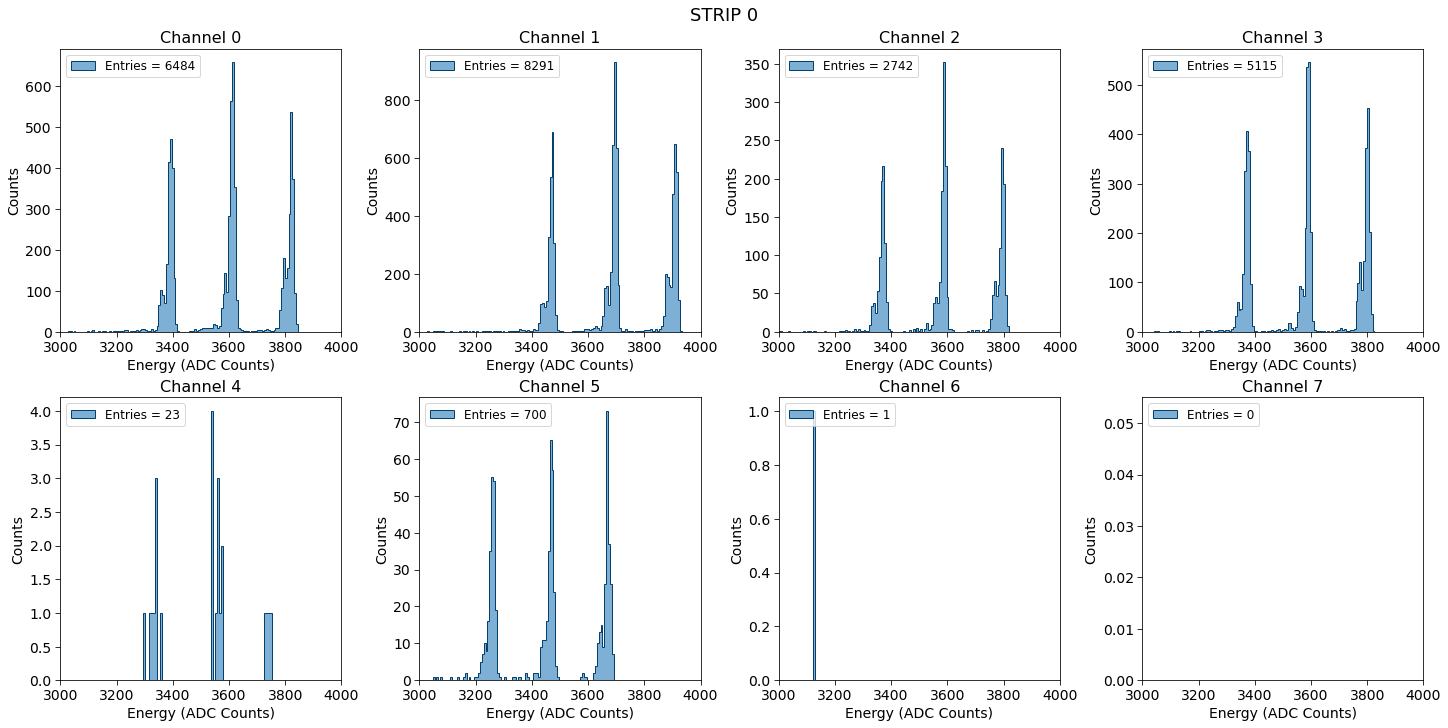

In [7]:
fig = plt.figure(figsize=(20,10), constrained_layout=True)
fig.suptitle(f"STRIP {STRIP_1_ID}", fontsize = FONTSIZE+4)

for c in range(8):
    
    n_entries = df_1_filtered.loc[(df_1_filtered["strip_ch"]==c), ].shape[0]
    
    bins = np.linspace(E_MIN, E_MAX, 150)
    
    ax = plot_strip_channels(
        df      = df_1_filtered, 
        bins    = bins,
        channel = c,
        fig     = fig,
        idx     = c+1,
        nrows   = 2,
        ncols   = 4,
        label   = f"Entries = {n_entries}"    
    )
    
    ax.legend(loc="upper left", fontsize=FONTSIZE-2)
    
    ax = customize_plot(
        ax       = ax, 
        fontsize = FONTSIZE,
        title    = f"Channel {c}",
        ylabel   = "Counts",
        xlabel   = "Energy (ADC Counts)",
        xleft    = E_MIN, 
        xright   = E_MAX, 
        ydown    = 0
    )

if SAVE_FIG:
    fig.savefig(f"{E_PLOT_PATH}/e-strip{STRIP_1_ID}.pdf", dpi=300, facecolor="white")

plt.show()

## Strip 2

In [8]:
df_2 = df.loc[(df["strip"] == STRIP_2_ID), ]

# filter
df_2_filtered = filter_energy(df_2, E_MIN, E_MAX)

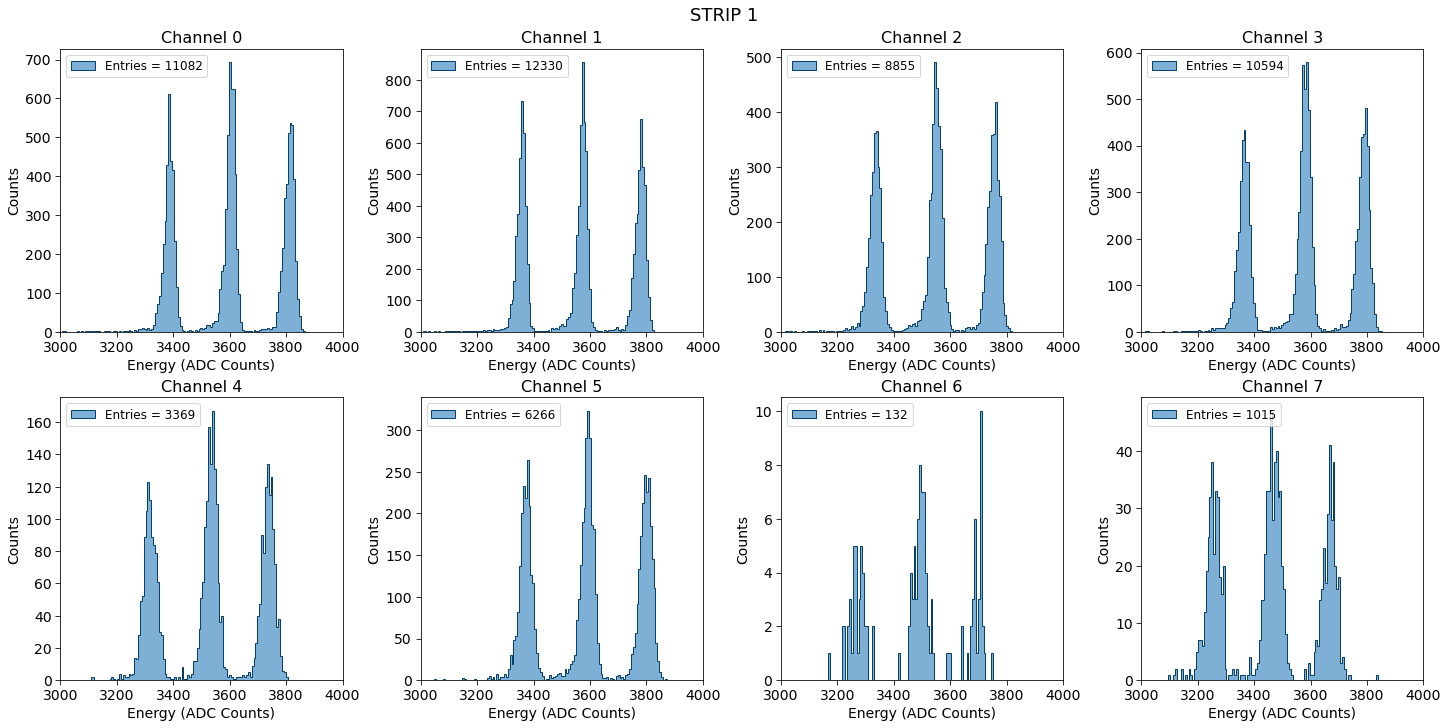

In [9]:
fig = plt.figure(figsize=(20,10), constrained_layout=True)
fig.suptitle(f"STRIP {STRIP_2_ID}", fontsize = FONTSIZE+4)

for c in range(8):
    
    n_entries = df_2_filtered.loc[(df_2_filtered["strip_ch"]==c), ].shape[0]
    
    bins = np.linspace(E_MIN, E_MAX, 150)
    
    ax = plot_strip_channels(
        df      = df_2_filtered, 
        bins    = bins,
        channel = c,
        fig     = fig,
        idx     = c+1,
        nrows   = 2,
        ncols   = 4,
        label   = f"Entries = {n_entries}"    
    )
    
    ax.legend(loc="upper left", fontsize=FONTSIZE-2)
    
    ax = customize_plot(
        ax       = ax, 
        fontsize = FONTSIZE,
        title    = f"Channel {c}",
        ylabel   = "Counts",
        xlabel   = "Energy (ADC Counts)",
        xleft    = E_MIN, 
        xright   = E_MAX, 
        ydown    = 0
    )

if SAVE_FIG:
    fig.savefig(f"{E_PLOT_PATH}/e-strip{STRIP_2_ID}.pdf", dpi=300, facecolor="white")
    
plt.show()

## Strip 3

In [10]:
df_3 = df.loc[(df["strip"] == STRIP_3_ID), ]

# filter
df_3_filtered = filter_energy(df_3, E_MIN, E_MAX)

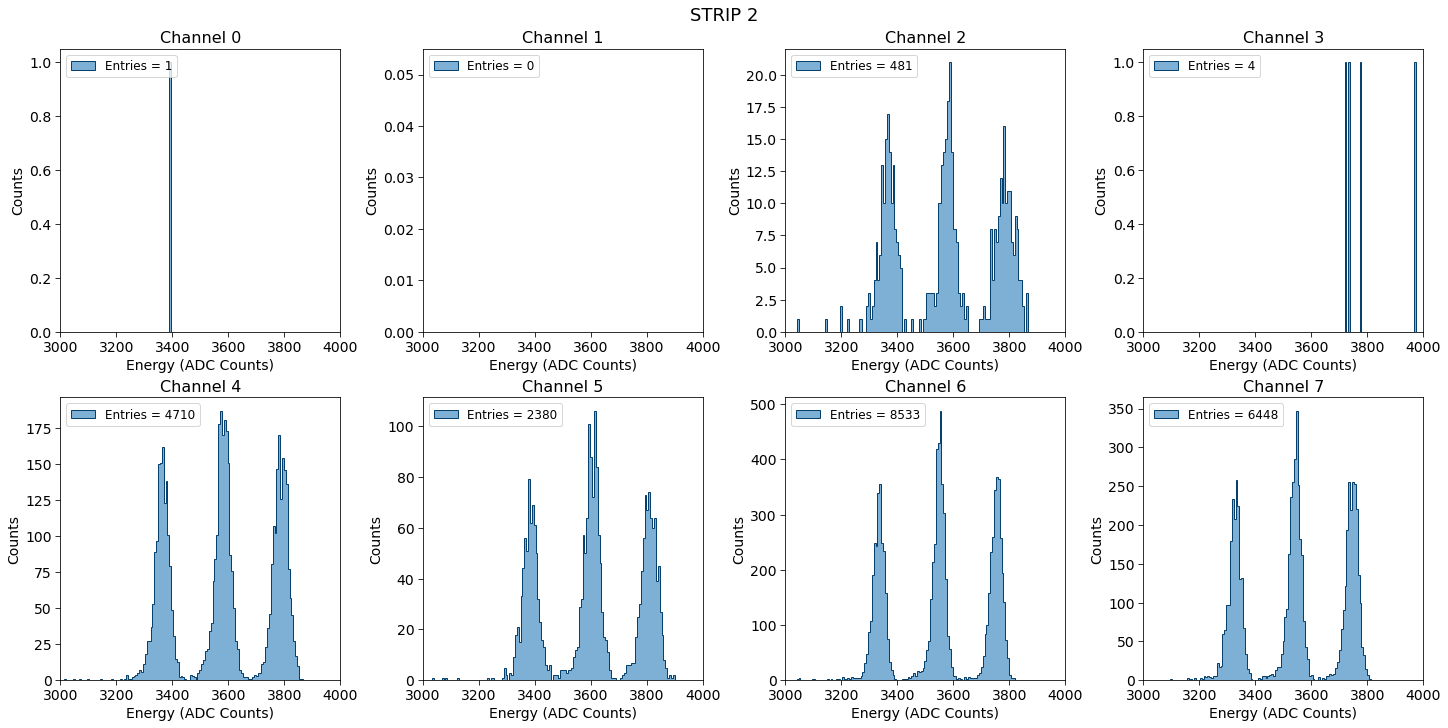

In [11]:
fig = plt.figure(figsize=(20,10), constrained_layout=True)
fig.suptitle(f"STRIP {STRIP_3_ID}", fontsize = FONTSIZE+4)

for c in range(8):
    
    n_entries = df_3_filtered.loc[(df_3_filtered["strip_ch"]==c), ].shape[0]
    
    bins = np.linspace(E_MIN, E_MAX, 150)
    
    ax = plot_strip_channels(
        df      = df_3_filtered, 
        bins    = bins,
        channel = c,
        fig     = fig,
        idx     = c+1,
        nrows   = 2,
        ncols   = 4,
        label   = f"Entries = {n_entries}"    
    )
    
    ax.legend(loc="upper left", fontsize=FONTSIZE-2)
    
    ax = customize_plot(
        ax       = ax, 
        fontsize = FONTSIZE,
        title    = f"Channel {c}",
        ylabel   = "Counts",
        xlabel   = "Energy (ADC Counts)",
        xleft    = E_MIN, 
        xright   = E_MAX, 
        ydown    = 0
    )

if SAVE_FIG:
    fig.savefig(f"{E_PLOT_PATH}/e-strip{STRIP_3_ID}.pdf", dpi=300, facecolor="white")
    
plt.show()

## Strip 4

In [12]:
df_4 = df.loc[(df["strip"] == STRIP_4_ID), ]

# filter
df_4_filtered = filter_energy(df_4, E_MIN, E_MAX)

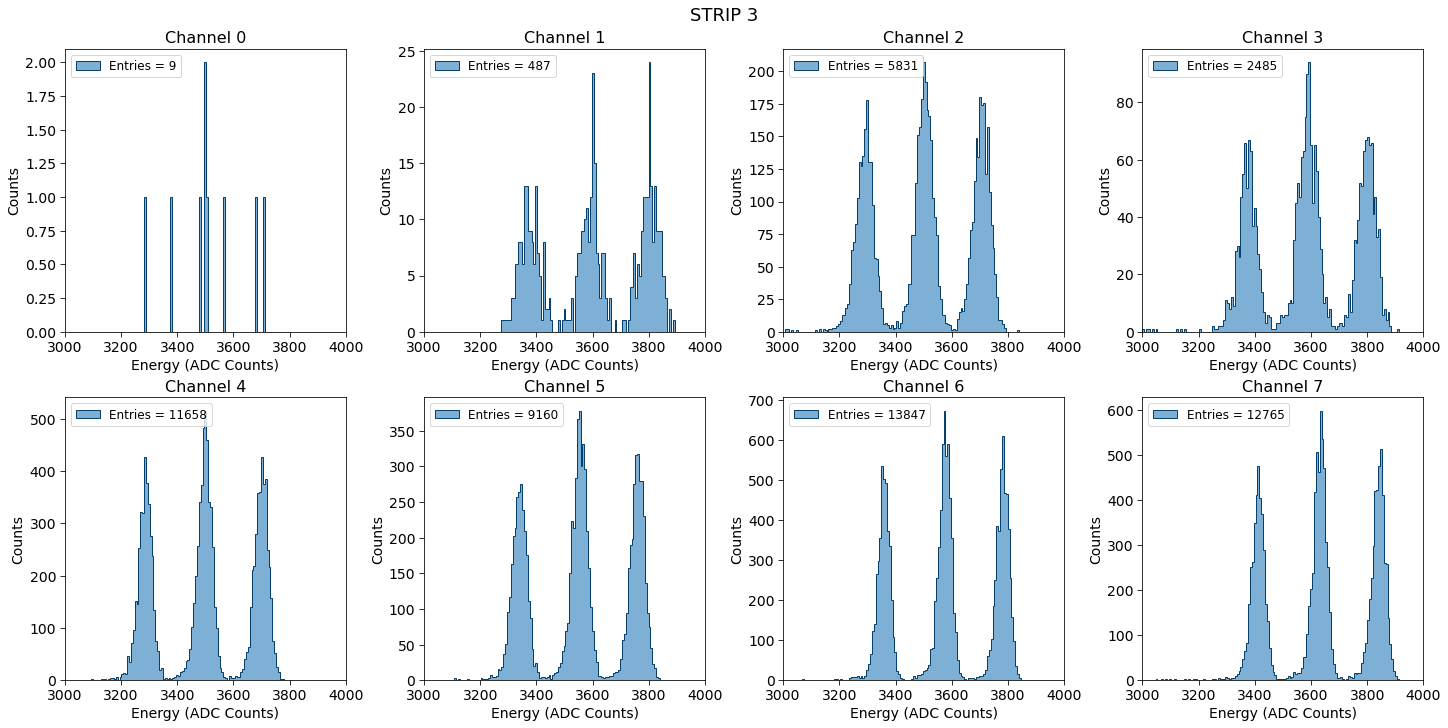

In [13]:
fig = plt.figure(figsize=(20,10), constrained_layout=True)
fig.suptitle(f"STRIP {STRIP_4_ID}", fontsize = FONTSIZE+4)

for c in range(8):
    
    n_entries = df_4_filtered.loc[(df_4_filtered["strip_ch"]==c), ].shape[0]
    
    bins = np.linspace(E_MIN, E_MAX, 150)
    
    ax = plot_strip_channels(
        df      = df_4_filtered, 
        bins    = bins,
        channel = c,
        fig     = fig,
        idx     = c+1,
        nrows   = 2,
        ncols   = 4,
        label   = f"Entries = {n_entries}"    
    )
    
    ax.legend(loc="upper left", fontsize=FONTSIZE-2)
    
    ax = customize_plot(
        ax       = ax, 
        fontsize = FONTSIZE,
        title    = f"Channel {c}",
        ylabel   = "Counts",
        xlabel   = "Energy (ADC Counts)",
        xleft    = E_MIN, 
        xright   = E_MAX, 
        ydown    = 0
    )

if SAVE_FIG:
    fig.savefig(f"{E_PLOT_PATH}/e-strip{STRIP_4_ID}.pdf", dpi=300, facecolor="white")
    
plt.show()

## Strip 5

In [7]:
df_5 = df.loc[(df["strip"] == STRIP_5_ID), ]

# filter
df_5_filtered = filter_energy(df_5, E_MIN, E_MAX)

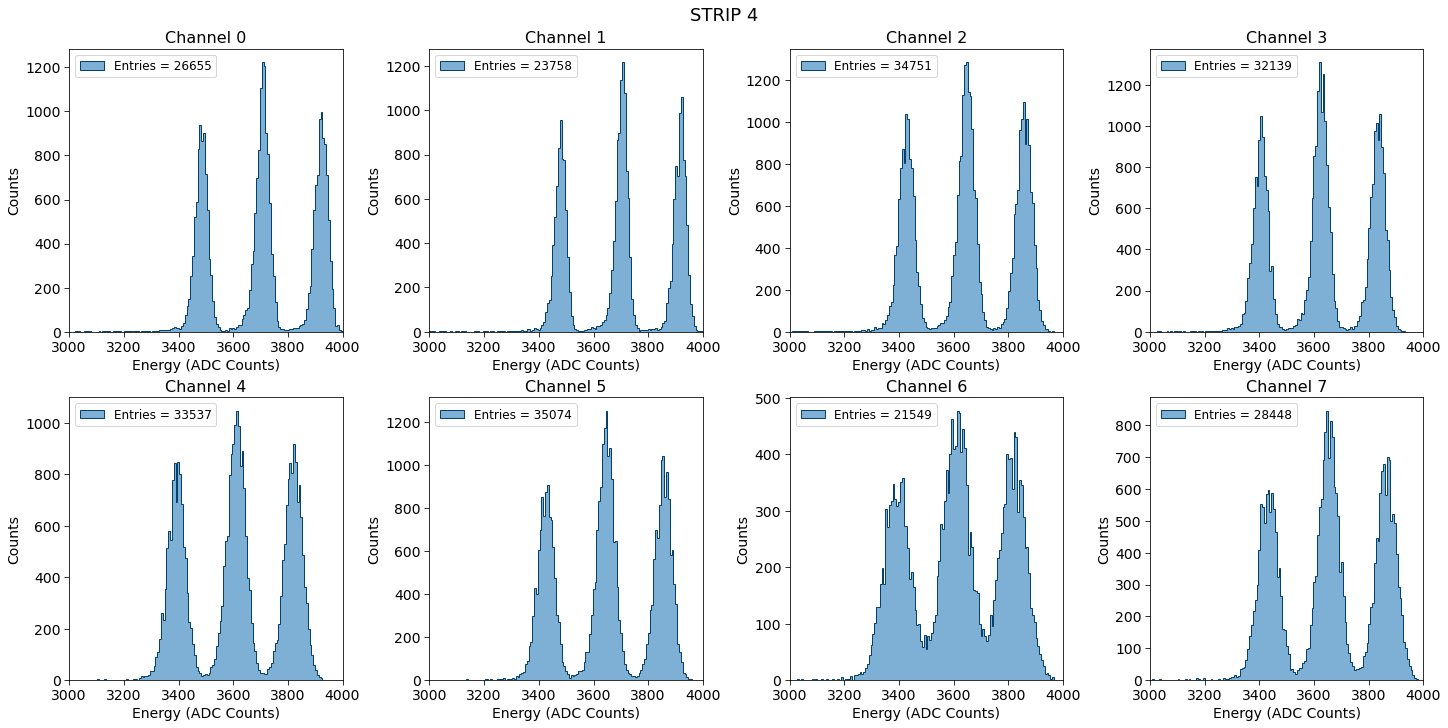

In [8]:
fig = plt.figure(figsize=(20,10), constrained_layout=True)
fig.suptitle(f"STRIP {STRIP_5_ID}", fontsize = FONTSIZE+4)

for c in range(8):
    
    n_entries = df_5_filtered.loc[(df_5_filtered["strip_ch"]==c), ].shape[0]
    
    bins = np.linspace(E_MIN, E_MAX, 150)
    
    ax = plot_strip_channels(
        df      = df_5_filtered, 
        bins    = bins,
        channel = c,
        fig     = fig,
        idx     = c+1,
        nrows   = 2,
        ncols   = 4,
        label   = f"Entries = {n_entries}"    
    )
    
    ax.legend(loc="upper left", fontsize=FONTSIZE-2)
    
    ax = customize_plot(
        ax       = ax, 
        fontsize = FONTSIZE,
        title    = f"Channel {c}",
        ylabel   = "Counts",
        xlabel   = "Energy (ADC Counts)",
        xleft    = E_MIN, 
        xright   = E_MAX, 
        ydown    = 0
    )

if SAVE_FIG:
    fig.savefig(f"{E_PLOT_PATH}/e-strip{STRIP_5_ID}.pdf", dpi=300, facecolor="white")
    
plt.show()

## Strip 6

In [16]:
df_6 = df.loc[(df["strip"] == STRIP_6_ID), ]

# filter
df_6_filtered = filter_energy(df_6, E_MIN, E_MAX)

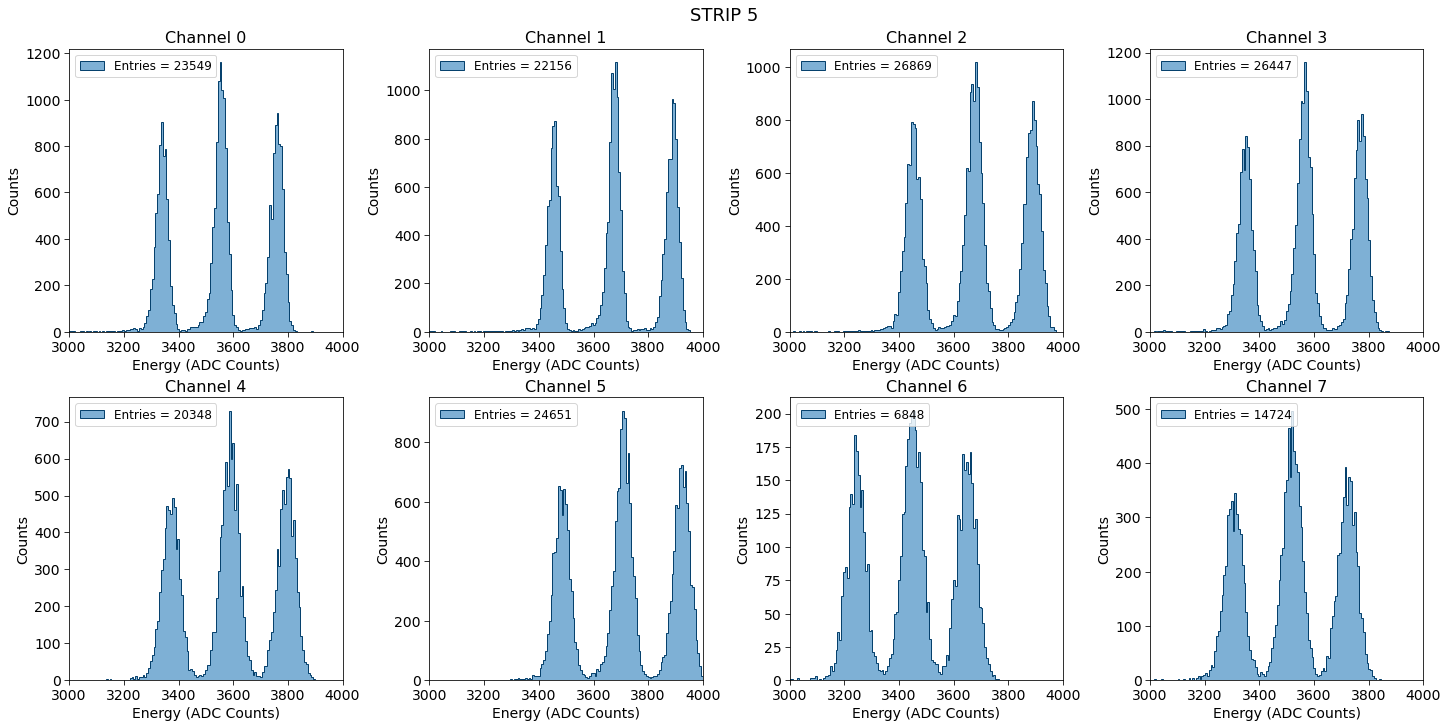

In [17]:
fig = plt.figure(figsize=(20,10), constrained_layout=True)
fig.suptitle(f"STRIP {STRIP_6_ID}", fontsize = FONTSIZE+4)

for c in range(8):
    
    n_entries = df_6_filtered.loc[(df_6_filtered["strip_ch"]==c), ].shape[0]
    
    bins = np.linspace(E_MIN, E_MAX, 150)
    
    ax = plot_strip_channels(
        df      = df_6_filtered, 
        bins    = bins,
        channel = c,
        fig     = fig,
        idx     = c+1,
        nrows   = 2,
        ncols   = 4,
        label   = f"Entries = {n_entries}"    
    )
    
    ax.legend(loc="upper left", fontsize=FONTSIZE-2)
    
    ax = customize_plot(
        ax       = ax, 
        fontsize = FONTSIZE,
        title    = f"Channel {c}",
        ylabel   = "Counts",
        xlabel   = "Energy (ADC Counts)",
        xleft    = E_MIN, 
        xright   = E_MAX, 
        ydown    = 0
    )

if SAVE_FIG:
    fig.savefig(f"{E_PLOT_PATH}/e-strip{STRIP_6_ID}.pdf", dpi=300, facecolor="white")
    
plt.show()

## Strip 7

In [9]:
df_7 = df.loc[(df["strip"] == STRIP_7_ID), ]

# filter
df_7_filtered = filter_energy(df_7, E_MIN, E_MAX)

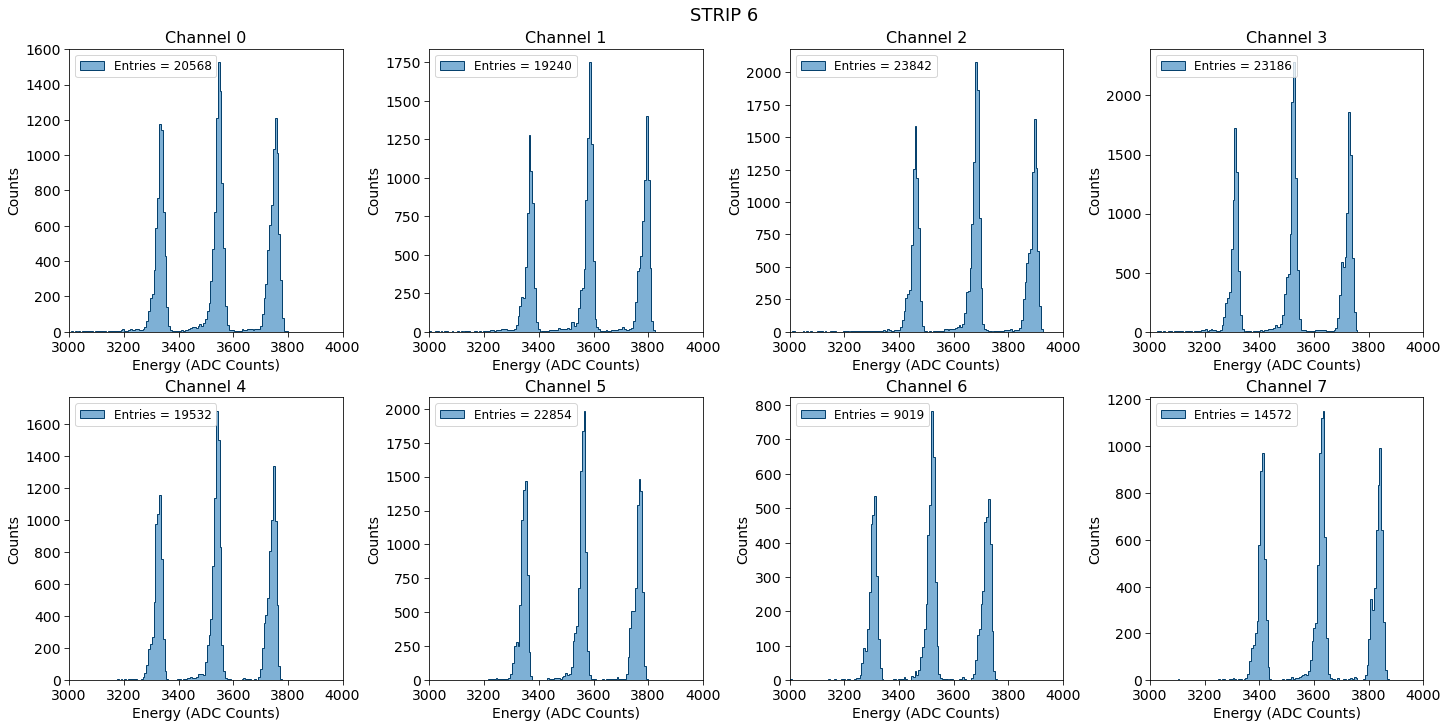

In [10]:
fig = plt.figure(figsize=(20,10), constrained_layout=True)
fig.suptitle(f"STRIP {STRIP_7_ID}", fontsize = FONTSIZE+4)

for c in range(8):
    
    n_entries = df_7_filtered.loc[(df_7_filtered["strip_ch"]==c), ].shape[0]
    
    bins = np.linspace(E_MIN, E_MAX, 150)
    
    ax = plot_strip_channels(
        df      = df_7_filtered, 
        bins    = bins,
        channel = c,
        fig     = fig,
        idx     = c+1,
        nrows   = 2,
        ncols   = 4,
        label   = f"Entries = {n_entries}"    
    )
    
    ax.legend(loc="upper left", fontsize=FONTSIZE-2)
    
    ax = customize_plot(
        ax       = ax, 
        fontsize = FONTSIZE,
        title    = f"Channel {c}",
        ylabel   = "Counts",
        xlabel   = "Energy (ADC Counts)",
        xleft    = E_MIN, 
        xright   = E_MAX, 
        ydown    = 0
    )

if SAVE_FIG:
    fig.savefig(f"{E_PLOT_PATH}/e-strip{STRIP_7_ID}.pdf", dpi=300, facecolor="white")
    
plt.show()

## Calibration

### good calibration

We choose Strip 7 (encoded in Strip 6 starting from 0) Channel 6

In [8]:
strip_1   = STRIP_7_ID
channel_1 = 6

emin_1 = 3200
emax_1 = 3800

df_calib_1 = filter_energy(df.loc[((df["strip"] == strip_1) & (df["strip_ch"] == channel_1)), ],  emin_1, emax_1)

In [9]:
# number of entries in the selected strip and channel
n_entries = df_calib_1.shape[0]

# define the binning
bins = np.linspace(emin_1, emax_1, 150)

# build the histogram
x, h, e = make_binning(df_calib_1, bins)

# define a continuous x coordinate for the fit
continuous_x = np.linspace(emin_1, emax_1, 1000)

# error on the histogram
err_h = np.sqrt(h)
# avoid division by zero
err_h[h==0] = 1

# find the three peaks automatically
peaks, prop = scipy.signal.find_peaks(x = h, prominence=100)

# define the empty lists for the fit parameters of the three peaks
norms_1      = []
means_1      = []
sigmas_1     = []
err_norms_1  = []
err_means_1  = []
err_sigmas_1 = []
chisqs_1     = []

# fit restrictions for each peak defined as x deviation from the mean
restrictions = [
    (22, 30),
    (15, 25),
    (15, 24)
]

# for each peak
for i, x_peak in enumerate(x[peaks]):
    
    # find the left and right boundaries of the peak
    left_base  = x[prop["left_bases"][i]]
    right_base = x[prop["right_bases"][i]]

    # compute a better approximation of the peak boundaries
    approx_width = (right_base - left_base) / 3

    # define the fit range
    fit_restriction = (x > x_peak - restrictions[i][0]) & (x < x_peak + restrictions[i][1])
    
    # fit the peak
    par, cov = scipy.optimize.curve_fit(
        f     = gaussian, 
        xdata = x[fit_restriction],
        ydata = h[fit_restriction],
        p0    = [n_entries/3, x_peak, approx_width],
        sigma = err_h[fit_restriction],
        absolute_sigma=True,
    )
    
    # compute the errors on parameters
    par_err = []
    for j in range(len(par)):
        try:
            par_err.append(np.absolute(cov[j][j])**0.5)
        except Exception:
            par_err.append( 0.00 )

    # residuals
    res   = h - gaussian(x, *par)
    # chi square
    chisq = np.sum((res / err_h)**2)

    # append the fit parameters
    norms_1.append(par[0])
    means_1.append(par[1])
    sigmas_1.append(np.abs(par[2]))
    err_norms_1.append(par_err[0])
    err_means_1.append(par_err[1])
    err_sigmas_1.append(par_err[2])
    chisqs_1.append(chisq)
    
    
# conversion to arrays
norms_1      = np.array(norms_1)
means_1      = np.array(means_1)
sigmas_1     = np.array(sigmas_1)
err_norms_1  = np.array(err_norms_1)
err_means_1  = np.array(err_means_1)
err_sigmas_1 = np.array(err_sigmas_1)
chisqs_1     = np.array(chisqs_1)

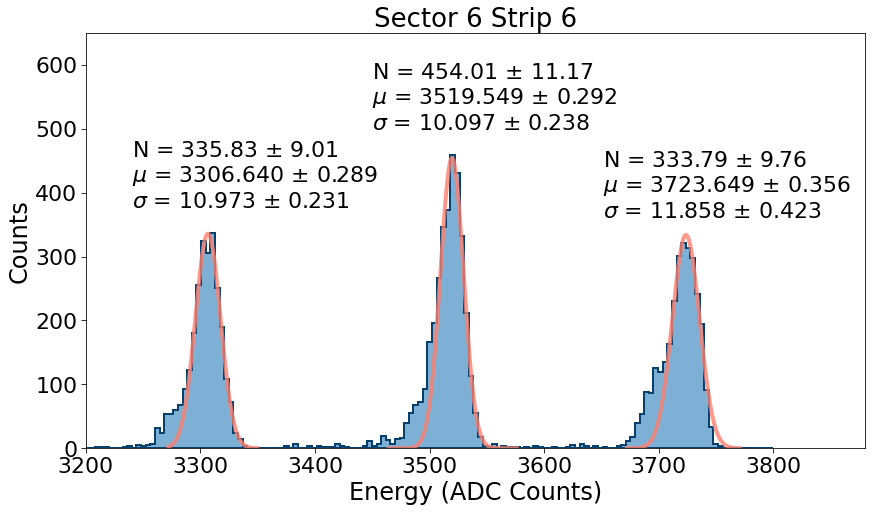

In [10]:
fig = plt.figure(figsize=(12,7), constrained_layout=True)

# plot the histogram
ax = plot_binned_hist(
    x     = x, 
    h     = h, 
    bins  = bins, 
    fig   = fig, 
    label = f"Entries = {n_entries}"
)

# ax.legend(loc="upper left", fontsize=FONTSIZE-2)

# plot customization
ax = customize_plot(
    ax       = ax, 
    fontsize = FONTSIZE,
    title    = f"Sector {strip_1} Strip {channel_1}",
    ylabel   = "Counts",
    xlabel   = "Energy (ADC Counts)",
    xleft    = emin_1, 
    xright   = emax_1 + 80, 
    ydown    = 0,
    yup      = 650
)

# plot gaussians
for i, x_peak in enumerate(x[peaks]):
    
    # compute peak boundaries
    left_base  = x[prop["left_bases"][i]]
    right_base = x[prop["right_bases"][i]]
    
    # define a better approximation of the peak boundaries
    approx_width = (right_base - left_base) / 3
    
    # plot_restriction = (continuous_x > x_peak - restrictions[i][0]) & (continuous_x < x_peak + restrictions[i][1])
    plot_restriction = (continuous_x > x_peak - approx_width) & (continuous_x < x_peak + approx_width)
    
    # plot the gaussian
    ax.plot(continuous_x[plot_restriction], gaussian(continuous_x[plot_restriction], norms_1[i], means_1[i], sigmas_1[i]), color="#fd7f6f", lw=4, alpha=0.8)
    
    # plot the fit parameters
    ax.text(x_peak - 70, prop["prominences"][i] + 20 + 100, f"N = {norms_1[i]:.2f} $\pm$ {err_norms_1[i]:.2f}",          transform=ax.transData, fontsize = FONTSIZE)
    ax.text(x_peak - 70, prop["prominences"][i] + 20 + 60,  f"$\mu$ = {means_1[i]:.3f} $\pm$ {err_means_1[i]:.3f}",      transform=ax.transData, fontsize = FONTSIZE)
    ax.text(x_peak - 70, prop["prominences"][i] + 20 + 20,  f"$\sigma$ = {sigmas_1[i]:.3f} $\pm$ {err_sigmas_1[i]:.3f}", transform=ax.transData, fontsize = FONTSIZE)

    
if SAVE_FIG:
    fig.savefig(f"{CALIB_PLOT_PATH}/e-strip{strip_1}channel{channel_1}.pdf", dpi=300, facecolor="white")
    
plt.show()

In [11]:
# reference energy
true_means = np.sort([E_AM, E_CM, E_PU])

# continuous x coordinate for the fit
true_means_continuous = np.linspace(5*1e3, 6*1e3, 1000)

# fit the calibration curve
plin_1, clin_1 = scipy.optimize.curve_fit(f=linear, xdata=true_means, ydata=means_1, sigma=err_means_1, absolute_sigma=True)

# compute the errors on parameters
plin_err_1 = []
for j in range(len(plin_1)):
    try:
        plin_err_1.append(np.absolute(clin_1[j][j])**0.5)
    except Exception:
        plin_err_1.append( 0.00 )

# residuals
res_1   = means_1 - linear(true_means, *plin_1)

# chi square
chisq_1 = np.sum((res_1 / err_means_1)**2)

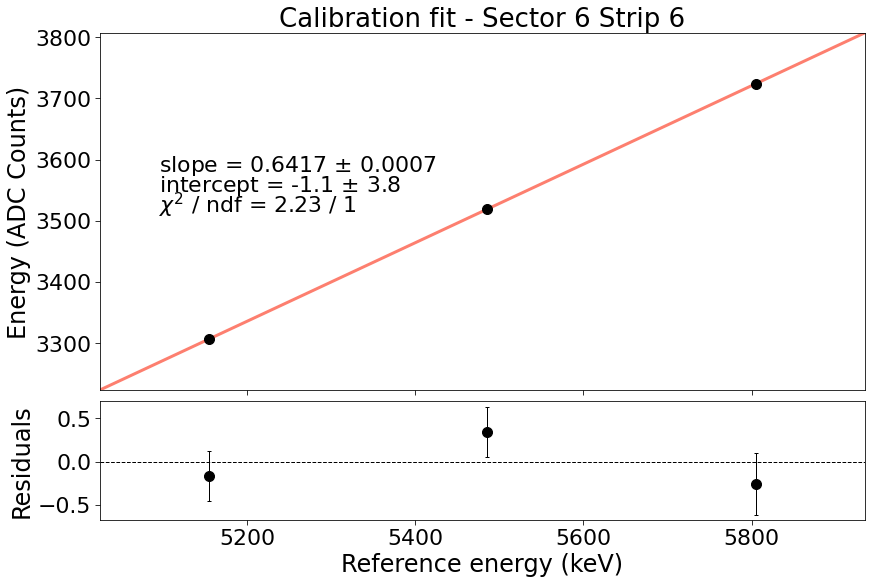

In [12]:
fig = plt.figure(figsize=(12,8), constrained_layout=True)

gs  = fig.add_gridspec(2, 1, height_ratios=[3, 1]) 
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex = ax1)

# plot data points: gaussian mean vs true energy
ax1.errorbar(
    x          = true_means, 
    y          = means_1, 
    yerr       = err_means_1, 
    linewidth  = 0, 
    marker     = '.', 
    markersize = 20, 
    elinewidth = 1, 
    capsize    = 2, 
    color      = "black"
)

# # plot customization
ax1 = customize_plot(
    ax       = ax1, 
    fontsize = FONTSIZE,
    title    = f"Calibration fit - Sector {strip_1} Strip {channel_1}",
    ylabel   = "Energy (ADC Counts)",
    xlabel   = None,  
    xleft    = true_means.min() - (true_means.max()-true_means.min())*0.2,
    xright   = true_means.max() + (true_means.max()-true_means.min())*0.2,
    ydown    = means_1.min() - (means_1.max()-means_1.min())*0.2,
    yup      = means_1.max() + (means_1.max()-means_1.min())*0.2,
)

# plot the fit
ax1.plot(true_means_continuous, linear(true_means_continuous, *plin_1), color="#fd7f6f", lw=3)

# plot the fit parameters
ax1.text(0.1, 0.85, f"slope = {plin_1[1]:.4f} $\pm$ {plin_err_1[1]:.4f}",     transform=ax.transAxes, fontsize = FONTSIZE)
ax1.text(0.1, 0.80, f"intercept = {plin_1[0]:.1f} $\pm$ {plin_err_1[0]:.1f}", transform=ax.transAxes, fontsize = FONTSIZE)
ax1.text(0.1, 0.75, f"$\chi^2$ / ndf = {chisq_1:.2f} / 1",                    transform=ax.transAxes, fontsize = FONTSIZE)

ax1.tick_params(labelbottom=False)


ax2.errorbar(
    x          = true_means, 
    y          = res_1, 
    yerr       = err_means_1, 
    linewidth  = 0, 
    marker     = '.', 
    markersize = 20, 
    elinewidth = 1, 
    capsize    = 2, 
    color      = "black"
)

ax2 = customize_plot(
    ax       = ax2, 
    fontsize = FONTSIZE,
    title    = None,
    ylabel   = "Residuals",
    xlabel   = "Reference energy (keV)",
)

ax2.axhline(color="black", linewidth=1, linestyle="dashed")

# fig.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{CALIB_PLOT_PATH}/calib-strip{strip_1}channel{channel_1}.pdf", dpi=300, facecolor="white")

plt.show()

In [13]:
# resolution of the peaks
resolution_good     = compute_resolution(means_1, sigmas_1)
resolution_good_err = compute_res_error(means_1, sigmas_1, err_means_1, err_sigmas_1)

for i, e in enumerate(true_means):
    print(f"{e:.0f} keV: {resolution_good[i]:.5f} +/- {resolution_good_err[i]:.5f}")

5155 keV: 0.00781 +/- 0.00016
5486 keV: 0.00676 +/- 0.00016
5805 keV: 0.00750 +/- 0.00027


In [15]:
avg_res_good     = compute_weighted_average(resolution_good, resolution_good_err)
avg_err_res_good = compute_weighted_average_error(resolution_good, resolution_good_err)

print(f"Average resolution: {avg_res_good:.5f} +/- {avg_err_res_good:.5f}")

Average resolution: 0.00730 +/- 0.00011


### bad calibration

We choose Strip 5 (encoded in Strip 4 starting from 0) Channel 6

In [17]:
strip_2   = STRIP_5_ID
channel_2 = 6

emin_2 = 3200
emax_2 = 4000

df_calib_2 = filter_energy(df.loc[((df["strip"] == strip_2) & (df["strip_ch"] == channel_2)), ],  emin_2, emax_2)

In [18]:
# number of entries in the selected strip and channel
n_entries = df_calib_2.shape[0]

# define the binning
bins = np.linspace(emin_2, emax_2, 150)

# build the histogram
x, h, e = make_binning(df_calib_2, bins)

# define a continuous x coordinate for the fit
continuous_x = np.linspace(emin_2, emax_2, 1000)

# error on the histogram
err_h = np.sqrt(h)
# avoid division by zero
err_h[h==0] = 1

# find the three peaks automatically
peaks, prop = scipy.signal.find_peaks(x = h, prominence=100)

# define the empty lists for the fit parameters of the three peaks
norms_2      = []
means_2      = []
sigmas_2     = []
err_norms_2  = []
err_means_2  = []
err_sigmas_2 = []
chisqs_2     = []

# fit restrictions for each peak defined as x deviation from the mean
restrictions = [
    (100, 100),
    (80, 80),  
    (70, 100), 
]

# for each peak
for i, x_peak in enumerate(x[peaks]):
    
    # find the left and right boundaries of the peak
    left_base  = x[prop["left_bases"][i]]
    right_base = x[prop["right_bases"][i]]

    # compute a better approximation of the peak boundaries
    approx_width = (right_base - left_base) / 2

    # define the fit range
    fit_restriction = (x > x_peak - restrictions[i][0]) & (x < x_peak + restrictions[i][1])
    
    # fit the peak
    par, cov = scipy.optimize.curve_fit(
        f     = gaussian, 
        xdata = x[fit_restriction],
        ydata = h[fit_restriction],
        p0    = [n_entries/3, x_peak, approx_width],
        sigma = err_h[fit_restriction],
        absolute_sigma=True,
    )
    
    # compute the errors on parameters
    par_err = []
    for j in range(len(par)):
        try:
            par_err.append(np.absolute(cov[j][j])**0.5)
        except Exception:
            par_err.append( 0.00 )

    # residuals
    res   = h - gaussian(x, *par)
    # chi square
    chisq = np.sum((res / err_h)**2)

    # append the fit parameters
    norms_2.append(par[0])
    means_2.append(par[1])
    sigmas_2.append(np.abs(par[2]))
    err_norms_2.append(par_err[0])
    err_means_2.append(par_err[1])
    err_sigmas_2.append(par_err[2])
    chisqs_2.append(chisq)
    
    
# conversion to arrays
norms_2      = np.array(norms_2)
means_2      = np.array(means_2)
sigmas_2     = np.array(sigmas_2)
err_norms_2  = np.array(err_norms_2)
err_means_2  = np.array(err_means_2)
err_sigmas_2 = np.array(err_sigmas_2)
chisqs_2     = np.array(chisqs_2)

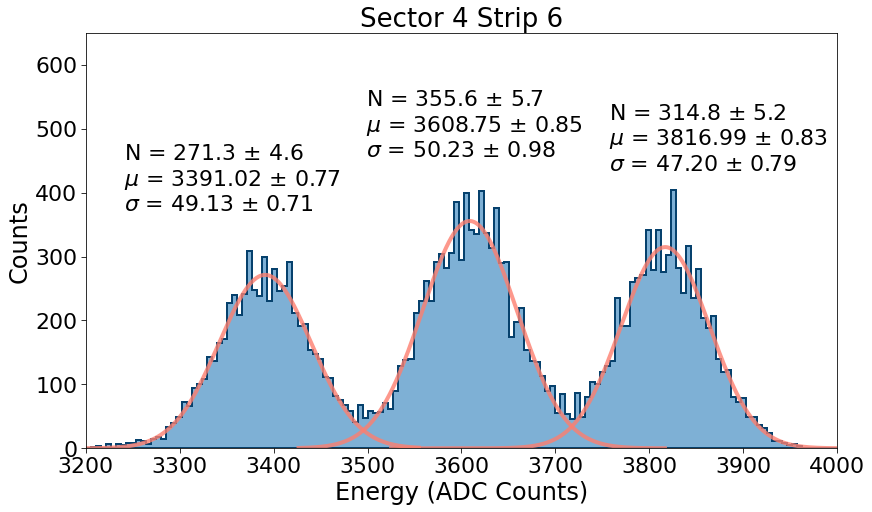

In [19]:
fig = plt.figure(figsize=(12,7), constrained_layout=True)

# plot the histogram
ax = plot_binned_hist(
    x     = x, 
    h     = h, 
    bins  = bins, 
    fig   = fig, 
    label = f"Entries = {n_entries}"
)

# ax.legend(loc="upper left", fontsize=FONTSIZE-2)

# plot customization
ax = customize_plot(
    ax       = ax, 
    fontsize = FONTSIZE,
    title    = f"Sector {strip_2} Strip {channel_2}",
    ylabel   = "Counts",
    xlabel   = "Energy (ADC Counts)",
    xleft    = emin_2, 
    xright   = emax_2, 
    ydown    = 0,
    yup      = 650
)

# plot gaussians
for i, x_peak in enumerate(x[peaks]):
    
    # compute peak boundaries
    left_base  = x[prop["left_bases"][i]]
    right_base = x[prop["right_bases"][i]]
    
    # define a better approximation of the peak boundaries
    if i == 0:
        approx_width = (right_base - left_base) * 0.7
    else:
        approx_width = (right_base - left_base) * 0.4
    
    # plot_restriction = (continuous_x > x_peak - restrictions[i][0]) & (continuous_x < x_peak + restrictions[i][1])
    plot_restriction = (continuous_x > x_peak - approx_width) & (continuous_x < x_peak + approx_width)
    
    # plot the gaussian
    ax.plot(continuous_x[plot_restriction], gaussian(continuous_x[plot_restriction], norms_2[i], means_2[i], sigmas_2[i]), color="#fd7f6f", lw=4, alpha=0.8)
    
    # plot the fit parameters
    if i == 0:
        ax.text(means_2[i] - 150, gaussian(means_2[i], norms_2[i], means_2[i], sigmas_2[i]) + 80 + 100, f"N = {norms_2[i]:.1f} $\pm$ {err_norms_2[i]:.1f}",          transform=ax.transData, fontsize = FONTSIZE)
        ax.text(means_2[i] - 150, gaussian(means_2[i], norms_2[i], means_2[i], sigmas_2[i]) + 80 + 60,  f"$\mu$ = {means_2[i]:.2f} $\pm$ {err_means_2[i]:.2f}",      transform=ax.transData, fontsize = FONTSIZE)
        ax.text(means_2[i] - 150, gaussian(means_2[i], norms_2[i], means_2[i], sigmas_2[i]) + 80 + 20,  f"$\sigma$ = {sigmas_2[i]:.2f} $\pm$ {err_sigmas_2[i]:.2f}", transform=ax.transData, fontsize = FONTSIZE)
    elif i == 1:
        ax.text(means_2[i] - 110, gaussian(means_2[i], norms_2[i], means_2[i], sigmas_2[i]) + 80 + 100, f"N = {norms_2[i]:.1f} $\pm$ {err_norms_2[i]:.1f}",          transform=ax.transData, fontsize = FONTSIZE)
        ax.text(means_2[i] - 110, gaussian(means_2[i], norms_2[i], means_2[i], sigmas_2[i]) + 80 + 60,  f"$\mu$ = {means_2[i]:.2f} $\pm$ {err_means_2[i]:.2f}",      transform=ax.transData, fontsize = FONTSIZE)
        ax.text(means_2[i] - 110, gaussian(means_2[i], norms_2[i], means_2[i], sigmas_2[i]) + 80 + 20,  f"$\sigma$ = {sigmas_2[i]:.2f} $\pm$ {err_sigmas_2[i]:.2f}", transform=ax.transData, fontsize = FONTSIZE)
    if i == 2:
        ax.text(means_2[i] - 60, gaussian(means_2[i], norms_2[i], means_2[i], sigmas_2[i]) + 100 + 100, f"N = {norms_2[i]:.1f} $\pm$ {err_norms_2[i]:.1f}",          transform=ax.transData, fontsize = FONTSIZE)
        ax.text(means_2[i] - 60, gaussian(means_2[i], norms_2[i], means_2[i], sigmas_2[i]) + 100 + 60,  f"$\mu$ = {means_2[i]:.2f} $\pm$ {err_means_2[i]:.2f}",      transform=ax.transData, fontsize = FONTSIZE)
        ax.text(means_2[i] - 60, gaussian(means_2[i], norms_2[i], means_2[i], sigmas_2[i]) + 100 + 20,  f"$\sigma$ = {sigmas_2[i]:.2f} $\pm$ {err_sigmas_2[i]:.2f}", transform=ax.transData, fontsize = FONTSIZE)

    
if SAVE_FIG:
    fig.savefig(f"{CALIB_PLOT_PATH}/e-strip{strip_2}channel{channel_2}.pdf", dpi=300, facecolor="white")
    
plt.show()

In [20]:
# reference energy
true_means = np.sort([E_AM, E_CM, E_PU])

# continuous x coordinate for the fit
true_means_continuous = np.linspace(5*1e3, 6*1e3, 1000)

# fit the calibration curve
plin_2, clin_2 = scipy.optimize.curve_fit(f=linear, xdata=true_means, ydata=means_2, sigma=err_means_2, absolute_sigma=True)

# compute the errors on parameters
plin_err_2 = []
for j in range(len(plin_2)):
    try:
        plin_err_2.append(np.absolute(clin_2[j][j])**0.5)
    except Exception:
        plin_err_2.append( 0.00 )

# residuals
res_2   = means_2 - linear(true_means, *plin_2)

# chi square
chisq_2 = np.sum((res_2 / err_means_2)**2)

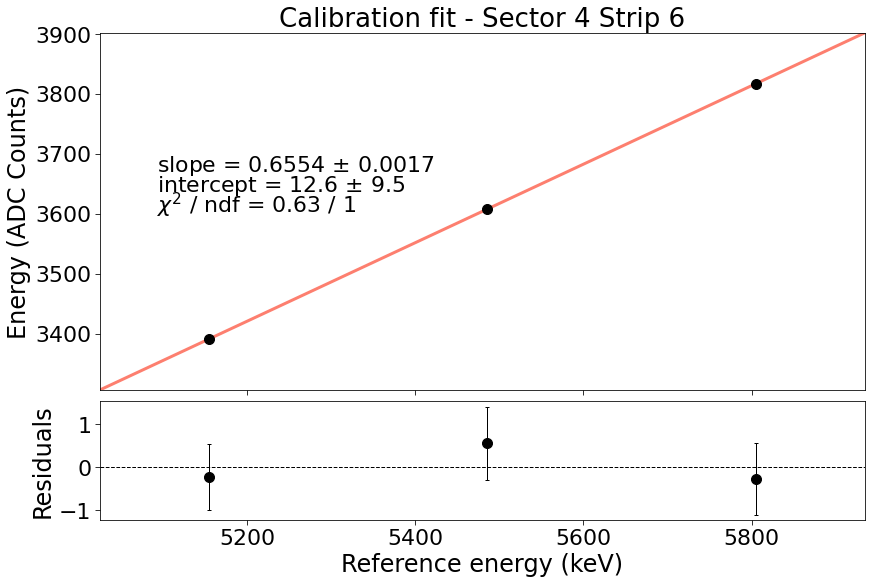

In [21]:
fig = plt.figure(figsize=(12,8), constrained_layout=True)

gs  = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[3, 1]) 
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex = ax1)

# plot data points: gaussian mean vs true energy
ax1.errorbar(
    x          = true_means, 
    y          = means_2, 
    yerr       = err_means_2, 
    linewidth  = 0, 
    marker     = '.', 
    markersize = 20, 
    elinewidth = 1, 
    capsize    = 2, 
    color      = "black"
)

# plot customization
ax1 = customize_plot(
    ax       = ax1, 
    fontsize = FONTSIZE,
    title    = f"Calibration fit - Sector {strip_2} Strip {channel_2}",
    ylabel   = "Energy (ADC Counts)",
    xlabel   = None,  
    xleft    = true_means.min() - (true_means.max()-true_means.min())*0.2,
    xright   = true_means.max() + (true_means.max()-true_means.min())*0.2,
    ydown    = means_2.min() - (means_2.max()-means_2.min())*0.2,
    yup      = means_2.max() + (means_2.max()-means_2.min())*0.2,
)

ax1.tick_params(labelbottom=False)

# plot the fit
ax1.plot(true_means_continuous, linear(true_means_continuous, *plin_2), color="#fd7f6f", lw=3)

# plot the fit parameters
ax1.text(0.1, 0.85, f"slope = {plin_2[1]:.4f} $\pm$ {plin_err_2[1]:.4f}",     transform=ax.transAxes, fontsize = FONTSIZE)
ax1.text(0.1, 0.80, f"intercept = {plin_2[0]:.1f} $\pm$ {plin_err_2[0]:.1f}", transform=ax.transAxes, fontsize = FONTSIZE)
ax1.text(0.1, 0.75, f"$\chi^2$ / ndf = {chisq_2:.2f} / 1",                    transform=ax.transAxes, fontsize = FONTSIZE)


ax2.errorbar(
    x          = true_means, 
    y          = res_2, 
    yerr       = err_means_2, 
    linewidth  = 0, 
    marker     = '.', 
    markersize = 20, 
    elinewidth = 1, 
    capsize    = 2, 
    color      = "black"
)

ax2 = customize_plot(
    ax       = ax2, 
    fontsize = FONTSIZE,
    title    = None,
    ylabel   = "Residuals",
    xlabel   = "Reference energy (keV)",
)

ax2.axhline(color="black", linewidth=1, linestyle="dashed")

if SAVE_FIG:
    fig.savefig(f"{CALIB_PLOT_PATH}/calib-strip{strip_2}channel{channel_2}.pdf", dpi=300, facecolor="white")

plt.show()

In [22]:
# resolution of the peaks
resolution_bad    = compute_resolution(means_2, sigmas_2)
resolution_bad_err = compute_res_error(means_2, sigmas_2, err_means_2, err_sigmas_2)

for i, e in enumerate(true_means):
    print(f"{e:.0f} keV: {resolution_bad[i]:.5f} +/- {resolution_bad_err[i]:.5f}")

5155 keV: 0.03412 +/- 0.00049
5486 keV: 0.03278 +/- 0.00064
5805 keV: 0.02912 +/- 0.00049


In [23]:
avg_res_bad     = compute_weighted_average(resolution_bad, resolution_bad_err)
avg_err_res_bad = compute_weighted_average_error(resolution_bad, resolution_bad_err)

print(f"Average resolution: {avg_res_bad:.5f} +/- {avg_err_res_bad:.5f}")

Average resolution: 0.03186 +/- 0.00030


### comparison

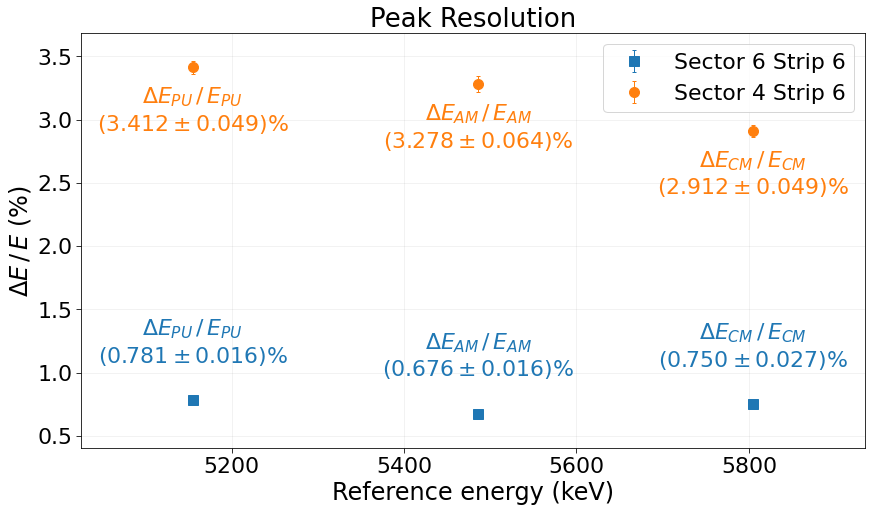

In [18]:
fig = plt.figure(figsize=(12,7), constrained_layout=True)

ax = fig.add_subplot(111)
ax.grid(color="grey", alpha=0.1, linestyle="solid", linewidth=1)

ax.errorbar(
    x          = true_means, 
    y          = resolution_good*1e2, 
    yerr       = resolution_good_err*1e2, 
    linewidth  = 0, 
    marker     = 's', 
    markersize = 10, 
    elinewidth = 1, 
    capsize    = 2, 
    color      = "tab:blue", 
    label      = "Sector 6 Strip 6"
)
ax.errorbar(
    x          = true_means, 
    y          = resolution_bad*1e2, 
    yerr       = resolution_bad_err*1e2, 
    linewidth  = 0, 
    marker     = 'o', 
    markersize = 10, 
    elinewidth = 1, 
    capsize    = 2, 
    color      = "tab:orange", 
    label      = "Sector 4 Strip 6"
)
ax.legend(loc="upper right", fontsize=FONTSIZE)

ax = customize_plot(
    ax=ax,
    fontsize = FONTSIZE,
    title    = "Peak Resolution",
    ylabel   = "$\Delta E\,/\,E$ (%)",
    xlabel   = "Reference energy (keV)",  
    xleft    = true_means.min() - (true_means.max()-true_means.min())*0.2,
    xright   = true_means.max() + (true_means.max()-true_means.min())*0.2,
    ydown    = resolution_good.min()*1e2 - (resolution_bad.max()-resolution_good.min())*1e2 * 0.1,
    yup      = resolution_bad.max()*1e2  + (resolution_bad.max()-resolution_good.min())*1e2 * 0.1,
)

ax.text(
    true_means[0], 
    resolution_bad[0]*1e2 - 0.5, 
    "$\Delta E_{PU} \,/\,  E_{PU}$\n$(%.3f \pm %.3f)$%%" % (resolution_bad[0]*1e2, resolution_bad_err[0]*1e2), 
    transform = ax.transData, 
    fontsize  = FONTSIZE, 
    color     = "tab:orange",
    horizontalalignment = "center"
)
ax.text(
    true_means[1], 
    resolution_bad[1]*1e2 - 0.5, 
    "$\Delta E_{AM} \,/\,  E_{AM}$\n$(%.3f \pm %.3f)$%%" % (resolution_bad[1]*1e2, resolution_bad_err[1]*1e2), 
    transform = ax.transData, 
    fontsize  = FONTSIZE, 
    color     = "tab:orange",
    horizontalalignment = "center"
)
ax.text(
    true_means[2], 
    resolution_bad[2]*1e2 - 0.5, 
    "$\Delta E_{CM} \,/\,  E_{CM}$\n$(%.3f \pm %.3f)$%%" % (resolution_bad[2]*1e2, resolution_bad_err[2]*1e2), 
    transform = ax.transData, 
    fontsize  = FONTSIZE, 
    color     = "tab:orange",
    horizontalalignment = "center"
)
ax.text(
    true_means[0], 
    resolution_good[0]*1e2 + 0.3, 
    "$\Delta E_{PU} \,/\,  E_{PU}$\n$(%.3f \pm %.3f)$%%" % (resolution_good[0]*1e2, resolution_good_err[0]*1e2), 
    transform = ax.transData, 
    fontsize  = FONTSIZE, 
    color     = "tab:blue",
    horizontalalignment = "center"
)
ax.text(
    true_means[1], 
    resolution_good[1]*1e2 + 0.3, 
    "$\Delta E_{AM} \,/\,  E_{AM}$\n$(%.3f \pm %.3f)$%%" % (resolution_good[1]*1e2, resolution_good_err[1]*1e2), 
    transform = ax.transData, 
    fontsize  = FONTSIZE, 
    color     = "tab:blue",
    horizontalalignment = "center"
)
ax.text(
    true_means[2], 
    resolution_good[2]*1e2 + 0.3, 
    "$\Delta E_{CM} \,/\,  E_{CM}$\n$(%.3f \pm %.3f)$%%" % (resolution_good[2]*1e2, resolution_good_err[2]*1e2), 
    transform = ax.transData, 
    fontsize  = FONTSIZE, 
    color     = "tab:blue",
    horizontalalignment = "center"
)

if SAVE_FIG:
    fig.savefig(f"{COMP_PLOT_PATH}/comp-resolution.pdf", dpi=300, facecolor="white")
    
plt.show()

### both calibrations in one plot

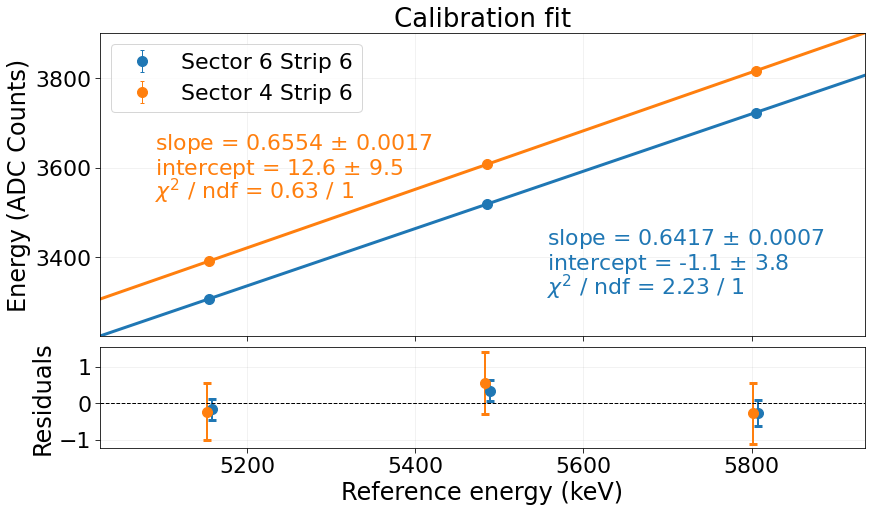

In [19]:
fig = plt.figure(figsize=(12,7), constrained_layout=True)

gs  = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[3, 1]) 
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex = ax1)

ax1.grid(color="grey", alpha=0.1, linestyle="solid", linewidth=1)
ax2.grid(color="grey", alpha=0.1, linestyle="solid", linewidth=1)

# plot data points: gaussian mean vs true energy
ax1.errorbar(
    x          = true_means, 
    y          = means_1, 
    yerr       = err_means_1, 
    linewidth  = 0, 
    marker     = '.', 
    markersize = 20, 
    elinewidth = 1, 
    capsize    = 2, 
    color      = "tab:blue",
    label      = "Sector 6 Strip 6"
)

# plot data points: gaussian mean vs true energy
ax1.errorbar(
    x          = true_means, 
    y          = means_2, 
    yerr       = err_means_2, 
    linewidth  = 0, 
    marker     = '.', 
    markersize = 20, 
    elinewidth = 1, 
    capsize    = 2, 
    color      = "tab:orange",
    label      = "Sector 4 Strip 6"
)

# plot customization
ax1 = customize_plot(
    ax       = ax1, 
    fontsize = FONTSIZE,
    title    = "Calibration fit",
    ylabel   = "Energy (ADC Counts)",
    xlabel   = None,  
    xleft    = true_means.min() - (true_means.max()-true_means.min())*0.2,
    xright   = true_means.max() + (true_means.max()-true_means.min())*0.2,
    ydown    = means_1.min() - (means_1.max()-means_1.min())*0.2,
    yup      = means_2.max() + (means_2.max()-means_2.min())*0.2,
)

ax1.legend(loc="upper left", fontsize=FONTSIZE)

ax1.tick_params(labelbottom=False)

# plot the fit
ax1.plot(true_means_continuous, linear(true_means_continuous, *plin_1), color="tab:blue", lw=3)
ax1.plot(true_means_continuous, linear(true_means_continuous, *plin_2), color="tab:orange", lw=3)

# plot the fit parameters
ax1.text(0.60, 0.65-0.15, f"slope = {plin_1[1]:.4f} $\pm$ {plin_err_1[1]:.4f}",     transform=ax.transAxes, fontsize = FONTSIZE, color="tab:blue")
ax1.text(0.60, 0.59-0.15, f"intercept = {plin_1[0]:.1f} $\pm$ {plin_err_1[0]:.1f}", transform=ax.transAxes, fontsize = FONTSIZE, color="tab:blue")
ax1.text(0.60, 0.53-0.15, f"$\chi^2$ / ndf = {chisq_1:.2f} / 1",                    transform=ax.transAxes, fontsize = FONTSIZE, color="tab:blue")

ax1.text(0.10, 0.85-0.12, f"slope = {plin_2[1]:.4f} $\pm$ {plin_err_2[1]:.4f}",     transform=ax.transAxes, fontsize = FONTSIZE, color="tab:orange")
ax1.text(0.10, 0.79-0.12, f"intercept = {plin_2[0]:.1f} $\pm$ {plin_err_2[0]:.1f}", transform=ax.transAxes, fontsize = FONTSIZE, color="tab:orange")
ax1.text(0.10, 0.73-0.12, f"$\chi^2$ / ndf = {chisq_2:.2f} / 1",                    transform=ax.transAxes, fontsize = FONTSIZE, color="tab:orange")


ax2.errorbar(
    x          = true_means + 3, 
    y          = res_1, 
    yerr       = err_means_1, 
    linewidth  = 0, 
    marker     = '.', 
    markersize = 20, 
    elinewidth = 2, 
    capsize    = 4, 
    capthick   = 3,
    color      = "tab:blue"
)

ax2.errorbar(
    x          = true_means - 3, 
    y          = res_2, 
    yerr       = err_means_2, 
    linewidth  = 0, 
    marker     = '.', 
    markersize = 20, 
    elinewidth = 2, 
    capsize    = 4, 
    capthick   = 3,
    color      = "tab:orange"
)

ax2 = customize_plot(
    ax       = ax2, 
    fontsize = FONTSIZE,
    title    = None,
    ylabel   = "Residuals",
    xlabel   = "Reference energy (keV)",
)

ax2.axhline(color="black", linewidth=1, linestyle="dashed")

if SAVE_FIG:
    fig.savefig(f"{COMP_PLOT_PATH}/comp-calib-fit.pdf", dpi=300, facecolor="white")

plt.show()